#  <span style="font-family: Latin Modern Roman; font-size: 35px; font-weight: bold;"> Práctica 1. Sistemas Distribuidos </span>

---

## <span style="font-family: Latin Modern Roman; font-size: 25px;"> Método de Montecarlo </span>


In [7]:
import random

def montecarlo_pi(num_samples):
    count_inside = 0
    for _ in range(num_samples):
        x, y = random.random(), random.random()
        if x**2 + y**2 <= 1:
            count_inside += 1
    return count_inside

## <span style="font-family: Latin Modern Roman; font-size: 25px;"> Máster </span>

In [8]:
import threading
import socket
import sys

print_lock = threading.Lock()

def master(num_samples, slave_ports):
    threads = []
    results = []
    samples_per_slave = num_samples // len(slave_ports)
    
    def send_task(port):
        try:
            master_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            master_socket.connect(('localhost', port))
            with print_lock:
                print(f"Master conectado a slave en ('localhost', {port})")
                sys.stdout.flush()
            master_socket.sendall(str(samples_per_slave).encode())
            result = int(master_socket.recv(1024).decode())
            results.append(result)
        except ConnectionRefusedError:
            with print_lock:
                print(f"Error: No se pudo conectar con el slave en el puerto {port}. Asegúrate de que está corriendo.")
                sys.stdout.flush()
        finally:
            master_socket.close()
    
    for port in slave_ports:
        thread = threading.Thread(target=send_task, args=(port,))
        thread.start()
        threads.append(thread)
    
    for thread in threads:
        thread.join()
    
    total_inside = sum(results)
    pi_estimate = (total_inside / num_samples) * 4
    with print_lock:
        print(f"Estimación de Pi: {pi_estimate}")
        sys.stdout.flush()

    return pi_estimate


## <span style="font-family: Latin Modern Roman; font-size: 25px;"> Slave </span>

In [9]:
def handle_slave_task(connection):
    try:
        task = connection.recv(1024).decode()
        num_samples = int(task)
        result = montecarlo_pi(num_samples)
        connection.sendall(str(result).encode())
    finally:
        connection.close()

In [10]:
def slave(port):
    server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server_socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
    server_socket.bind(('localhost', port))
    server_socket.listen()
    
    with print_lock:
        print(f"Slave esperando tareas en {server_socket.getsockname()}...")
        sys.stdout.flush()

    while True:
        connection, client_address = server_socket.accept()
        with print_lock:
            print(f"Slave en {server_socket.getsockname()} conectado con {client_address}")
            sys.stdout.flush()
        thread = threading.Thread(target=handle_slave_task, args=(connection,))
        thread.start()
        thread.join()
        server_socket.close()
        break

## <span style="font-family: Latin Modern Roman; font-size: 25px;"> Funcionamiento </span>

In [11]:
import time

num_samples = 1000000
num_slaves = 2
slave_ports = [9999, 10000]

slave_threads = []
for port in slave_ports:
    thread = threading.Thread(target=slave, args=(port,))
    thread.daemon = True
    thread.start()
    slave_threads.append(thread)

master(num_samples, slave_ports)

Slave esperando tareas en ('127.0.0.1', 9999)...
Slave esperando tareas en ('127.0.0.1', 10000)...
Master conectado a slave en ('localhost', 9999)
Master conectado a slave en ('localhost', 10000)
Slave en ('127.0.0.1', 9999) conectado con ('127.0.0.1', 50216)
Slave en ('127.0.0.1', 10000) conectado con ('127.0.0.1', 50217)
Estimación de Pi: 3.142524


3.142524

## <span style="font-family: Latin Modern Roman; font-size: 25px;"> Análisis de Rendimiento </span>

Slave esperando tareas en ('127.0.0.1', 9999)...
Slave esperando tareas en ('127.0.0.1', 10000)...
Master conectado a slave en ('localhost', 10000)
Master conectado a slave en ('localhost', 9999)
Slave en ('127.0.0.1', 10000) conectado con ('127.0.0.1', 50219)
Slave en ('127.0.0.1', 9999) conectado con ('127.0.0.1', 50220)
Estimación de Pi: 3.143508
Slave esperando tareas en ('127.0.0.1', 9999)...
Slave esperando tareas en ('127.0.0.1', 10000)...
Slave en ('127.0.0.1', 9999) conectado con ('127.0.0.1', 50223)
Master conectado a slave en ('localhost', 9999)
Master conectado a slave en ('localhost', 10000)
Slave en ('127.0.0.1', 10000) conectado con ('127.0.0.1', 50224)
Estimación de Pi: 3.143152
Slave esperando tareas en ('127.0.0.1', 9999)...
Slave esperando tareas en ('127.0.0.1', 10000)...
Master conectado a slave en ('localhost', 9999)
Master conectado a slave en ('localhost', 10000)
Slave en ('127.0.0.1', 9999) conectado con ('127.0.0.1', 50226)
Slave en ('127.0.0.1', 10000) conect

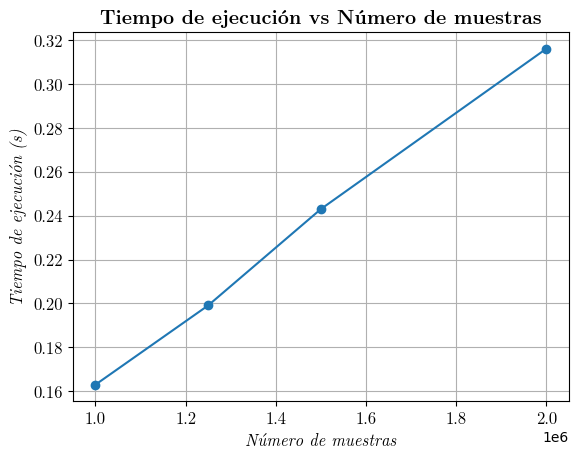

Slave esperando tareas en ('127.0.0.1', 9999)...
Master conectado a slave en ('localhost', 9999)
Slave en ('127.0.0.1', 9999) conectado con ('127.0.0.1', 50230)
Estimación de Pi: 3.142708
Slave esperando tareas en ('127.0.0.1', 9999)...
Slave esperando tareas en ('127.0.0.1', 10000)...
Master conectado a slave en ('localhost', 9999)
Slave en ('127.0.0.1', 9999) conectado con ('127.0.0.1', 50231)
Master conectado a slave en ('localhost', 10000)
Slave en ('127.0.0.1', 10000) conectado con ('127.0.0.1', 50232)
Estimación de Pi: 3.141544
Slave esperando tareas en ('127.0.0.1', 9999)...
Slave esperando tareas en ('127.0.0.1', 10000)...
Slave esperando tareas en ('127.0.0.1', 10001)...
Master conectado a slave en ('localhost', 9999)
Master conectado a slave en ('localhost', 10000)
Master conectado a slave en ('localhost', 10001)
Slave en ('127.0.0.1', 10001) conectado con ('127.0.0.1', 50236)
Slave en ('127.0.0.1', 9999) conectado con ('127.0.0.1', 50234)
Slave en ('127.0.0.1', 10000) conect

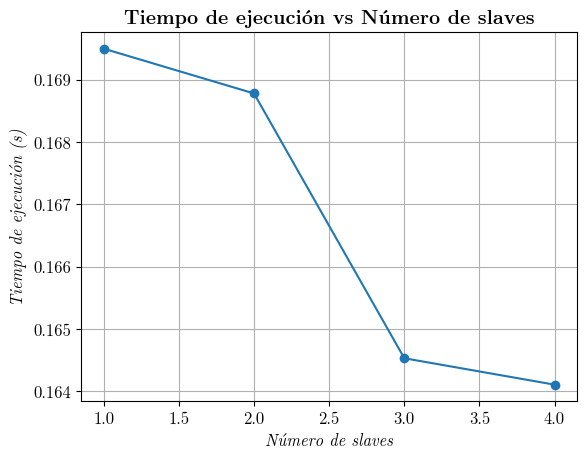

In [12]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path_regular = '/Users/sergiocuencanunez/Library/Fonts/lmroman10-regular.otf'
font_path_bold = '/Users/sergiocuencanunez/Library/Fonts/lmroman10-bold.otf'
font_path_italic = '/Users/sergiocuencanunez/Library/Fonts/lmroman10-italic.otf'

font_prop_regular = fm.FontProperties(fname=font_path_regular, size=12)
font_prop_bold = fm.FontProperties(fname=font_path_bold, size=14)
font_prop_italic = fm.FontProperties(fname=font_path_italic, size=12)

def measure_execution_time(num_samples, num_slaves):
    slave_ports = list(range(9999, 9999 + num_slaves))
    
    slave_threads = []
    for port in slave_ports:
        time.sleep(1)
        thread = threading.Thread(target=slave, args=(port,))
        thread.daemon = True
        thread.start()
        slave_threads.append(thread)
    
    time.sleep(2)
    
    start_time = time.time()
    master(num_samples, slave_ports)
    end_time = time.time()
    
    return end_time - start_time

samples_list = [1000000, 1250000, 1500000, 2000000]
execution_times_samples = [measure_execution_time(samples, 2) for samples in samples_list]

plt.figure()
plt.plot(samples_list, execution_times_samples, marker='o', linestyle='-')
plt.xlabel('Número de muestras', fontproperties=font_prop_italic)
plt.ylabel('Tiempo de ejecución (s)', fontproperties=font_prop_italic)
plt.title('Tiempo de ejecución vs Número de muestras', fontproperties=font_prop_bold)
plt.xticks(fontproperties=font_prop_regular)
plt.yticks(fontproperties=font_prop_regular)
plt.grid()
plt.show()

slaves_list = [1, 2, 3, 4]
execution_times_slaves = [measure_execution_time(1000000, slaves) for slaves in slaves_list]

plt.figure()
plt.plot(slaves_list, execution_times_slaves, marker='o', linestyle='-')
plt.xlabel('Número de slaves', fontproperties=font_prop_italic)
plt.ylabel('Tiempo de ejecución (s)', fontproperties=font_prop_italic)
plt.title('Tiempo de ejecución vs Número de slaves', fontproperties=font_prop_bold)
plt.xticks(fontproperties=font_prop_regular)
plt.yticks(fontproperties=font_prop_regular)
plt.grid()
plt.show()

---

## <span style="font-family: Latin Modern Roman; font-size: 25px;"> Elena Conderana Medem y Sergio Cuenca Núñez </span>